##**`Melanoma Detection Assignment`**
-SENTHIL KUMAR SELVAM

### 1. Importing all the important libraries and Validating its versions
##### 1.1 Importing Libraries
##### 1.2 Validating and Updating versions as needed
##### 1.3 Drive settings to access Datasets from Drive.
##### 1.4 Setting Test and Train path for access
##### 1.5 Understanding the size of data sets

In [1]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from google.colab import drive
from glob import glob

In [2]:
print("Versions:")
print(f"pathlib: Built into Python, version matches your Python version.")
print(f"TensorFlow: {tf.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"os: Built into Python, no version applicable.")
print(f"PIL: {PIL.__version__}")
print(f"Google Colab Drive: No specific version, use 'import drive' to mount.")
print(f"glob: Built into Python, no version applicable.")

Versions:
pathlib: Built into Python, version matches your Python version.
TensorFlow: 2.15.0
Matplotlib: 3.8.0
Seaborn: 0.13.2
Numpy: 1.26.4
Pandas: 2.2.2
os: Built into Python, no version applicable.
PIL: 11.0.0
Google Colab Drive: No specific version, use 'import drive' to mount.
glob: Built into Python, no version applicable.


In [3]:
## If you are using the data by mounting the google drive, use the following :
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# 2. Load using keras.preprocessing
### 2.1 Create a dataset
### 2.2 Visualize the data

### 2.1 Create a dataset
##### 2.1.1 Define parameters for the loader
##### 2.1.2 Segreating traning and test data (80:20)

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [9]:
class_names = train_ds.class_names
items_per_row = 1
# Loop through the class names and print them row by row
for i in range(0, len(class_names), items_per_row):
    print(" ".join(class_names[i:i + items_per_row]))

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


### 2.2 Visualize the data
##### 2.2.1 Visualizing the data set
##### 2.2.2 Visualizing No. of images belonging to a Type v/s Types of Skin Lesion
##### 2.2.3 Tuning the data

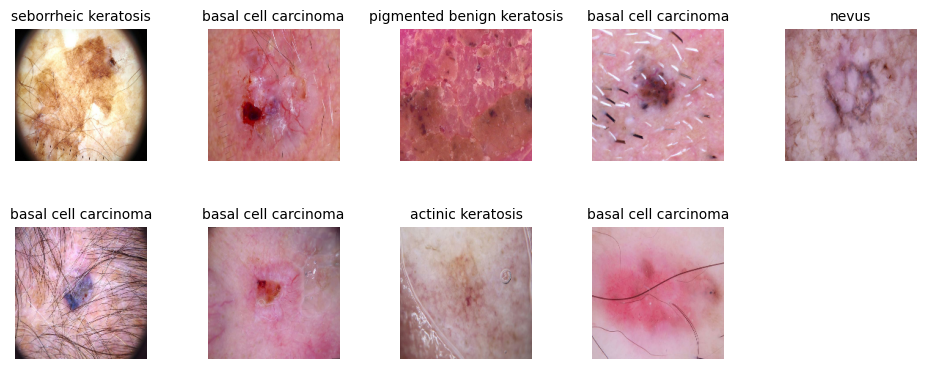

In [10]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=10)  # Adjust font size
        plt.axis("off")
plt.subplots_adjust(hspace=0.5)  # Increase space between subplots
plt.show()

<ipython-input-11-2c83f7751ed1>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="No. of Image", y="Class", data=df, palette=palette)


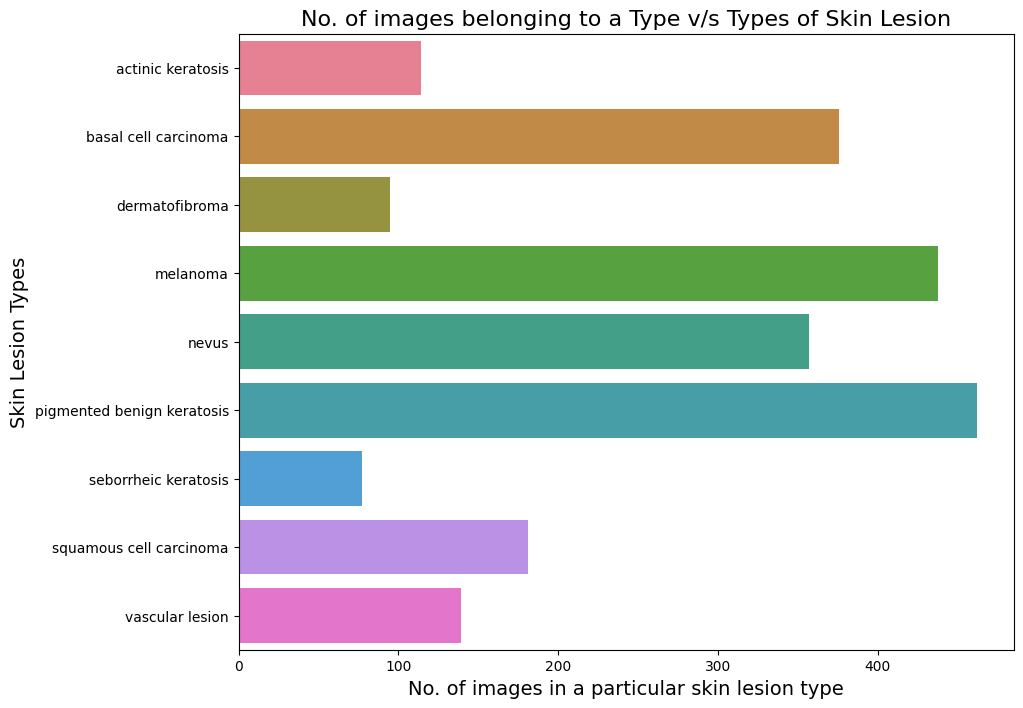

In [11]:
#Visualize the Number of image in each class.
# Create a DataFrame with the required columns 'No. of Image' and 'Class'
data = {'Class': class_names,
        'No. of Image': [len(list(data_dir_train.glob(f'{c}/*.jpg'))) for c in class_names]}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 8))

# Get a palette with the desired number of colors
palette = sns.color_palette("husl", len(df))

# Create the barplot with custom palette
ax = sns.barplot(x="No. of Image", y="Class", data=df, palette=palette)

plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Create the model "Model 1"
##### 3.1 Developing a CNN Model for Accurate 9-Class Classification with Pixel Value Normalization Using Rescaling Layer
##### 3.2 Compiling the model
##### 3.3 Training the model
##### 3.4 Visualizing the training result
##### 3.5 Observations


In [13]:
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Updated line: Removed 'layers.experimental.preprocessing.'
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 119s 153ms/step - loss: 1.6097 - accuracy: 0.3968 - val_loss: 1.2414 - val_accuracy: 0.5335
Epoch 2/20
394/394 [==============================] - 48s 121ms/step - loss: 1.0508 - accuracy: 0.6145 - val_loss: 0.8456 - val_accuracy: 0.7108
Epoch 3/20
394/394 [==============================] - 45s 115ms/step - loss: 0.7345 - accuracy: 0.7374 - val_loss: 0.7137 - val_accuracy: 0.7439
Epoch 4/20
394/394 [==============================] - 44s 112ms/step - loss: 0.4913 - accuracy: 0.8274 - val_loss: 0.4753 - val_accuracy: 0.8452
Epoch 5/20
394/394 [==============================] - 45s 113ms/step - loss: 0.3466 - accuracy: 0.8783 - val_loss: 0.4080 - val_accuracy: 0.8627
Epoch 6/20
394/394 [==============================] - 45s 114ms/step - loss: 0.2522 - accuracy: 0.9091 - val_loss: 0.4518 - val_accuracy: 0.8497
Epoch 7/20
394/394 [==============================] - 44s 112ms/step - loss: 0.2274 - accuracy: 0.9163 - val_loss: 0.3222 - val_a

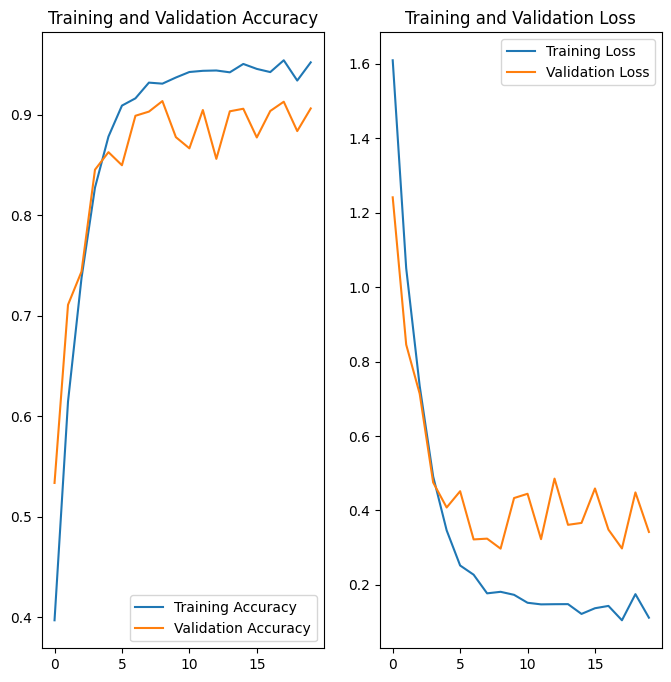

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Improvement in accuracy:** Training accuracy increases from 35.28% to 95.84% over 20 epochs, showing the model is learning well.

**Decreasing training loss:** Training loss drops from 1.6900 to 0.0963, indicating effective model convergence.

**Validation performance:** Validation accuracy improves from 48.91% to 87.98%, though it fluctuates in the middle epochs.

**Validation loss:** Validation loss initially decreases but fluctuates later, suggesting potential overfitting.

**Overfitting potential:** The model may be overfitting, as training accuracy keeps rising while validation accuracy plateaus or drops slightly in later epochs.

# 4. Create the model "Model 2"
##### 4.1 Developing a CNN Model for Robust Classification with Data Augmentation, Dropout Regularization, and Pixel Value Normalization Using Rescaling Layer
##### 4.2 Compiling the model
##### 4.3 Training the model
##### 4.4 Visualizing the training result
##### 4.5 Observations

In [18]:
augmentation_data = Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

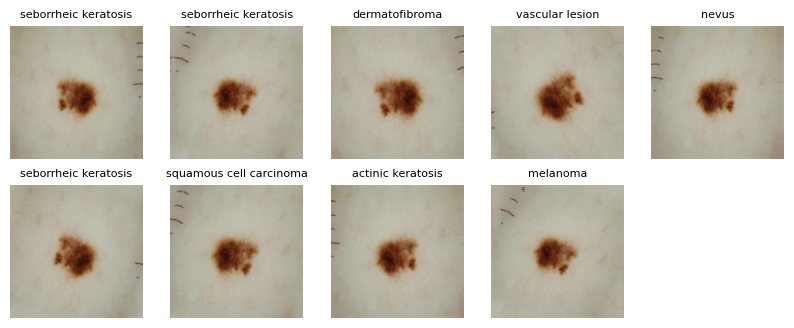

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=8)
        plt.axis("off")

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
    augmentation_data,
    layers.Rescaling(1./255),  # Updated
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)  # Ensure 'target_labels' is an integer or appropriate number of units
])

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 51s 126ms/step - loss: 1.7636 - accuracy: 0.3171 - val_loss: 1.4332 - val_accuracy: 0.4484
Epoch 2/20
394/394 [==============================] - 48s 123ms/step - loss: 1.3823 - accuracy: 0.4624 - val_loss: 1.2629 - val_accuracy: 0.5059
Epoch 3/20
394/394 [==============================] - 49s 124ms/step - loss: 1.2416 - accuracy: 0.5207 - val_loss: 1.1668 - val_accuracy: 0.5542
Epoch 4/20
394/394 [==============================] - 48s 122ms/step - loss: 1.1270 - accuracy: 0.5622 - val_loss: 1.0431 - val_accuracy: 0.6092
Epoch 5/20
394/394 [==============================] - 48s 122ms/step - loss: 1.0454 - accuracy: 0.6046 - val_loss: 1.1872 - val_accuracy: 0.5758
Epoch 6/20
394/394 [==============================] - 48s 123ms/step - loss: 0.9488 - accuracy: 0.6385 - val_loss: 0.8884 - val_accuracy: 0.6698
Epoch 7/20
394/394 [==============================] - 48s 122ms/step - loss: 0.8984 - accuracy: 0.6599 - val_loss: 0.8285 - val_ac

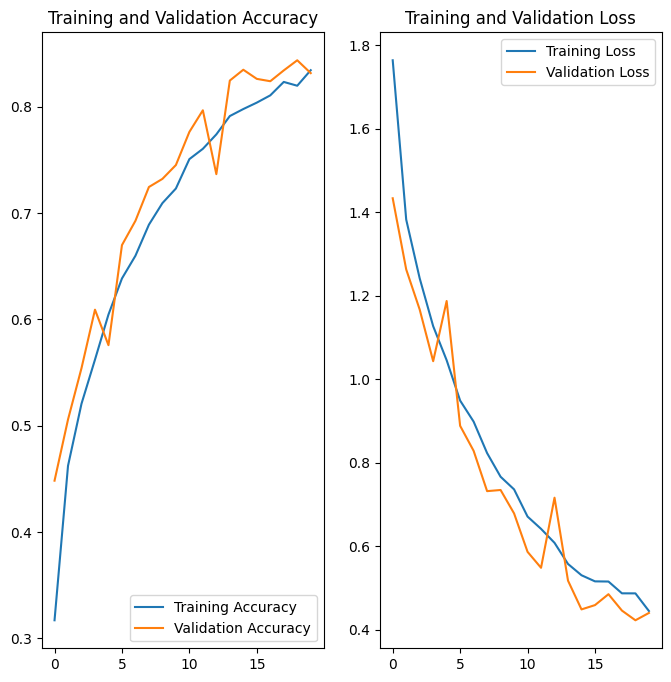

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Improvment in Accuracy:** Both training and validation accuracy improve over time (training: 34.76% to 83.51%, validation: 41.70% to 85.58%).

**Decreasing training loss:**  Training and validation loss decrease consistently, indicating better predictions (training: 1.7039 to 0.4470, validation: 1.5982 to 0.4471).

**Validation Performance:** Validation accuracy lags initially but exceeds training accuracy in later epochs, showing good generalization.

**Validation loss:** Accuracy plateaus around epoch 14-15, indicating diminishing returns in learning.

**Potential Overfitting:** Some validation loss fluctuations suggest slight overfitting, though overall validation performance remains stable.

# 5. Analyzing Class Distribution in Training Data for Imbalance Detection

In [24]:
## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [25]:
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0026720.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0025790.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0025350.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0026388.jpg', 'squamous cell carcinoma'), ('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0025358.jpg', 'squamous cell carcinoma')]


In [26]:
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/CNN_assignment/Skin c...,squamous cell carcinoma
1,/content/gdrive/My Drive/CNN_assignment/Skin c...,squamous cell carcinoma
2,/content/gdrive/My Drive/CNN_assignment/Skin c...,squamous cell carcinoma
3,/content/gdrive/My Drive/CNN_assignment/Skin c...,squamous cell carcinoma
4,/content/gdrive/My Drive/CNN_assignment/Skin c...,squamous cell carcinoma


In [27]:
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


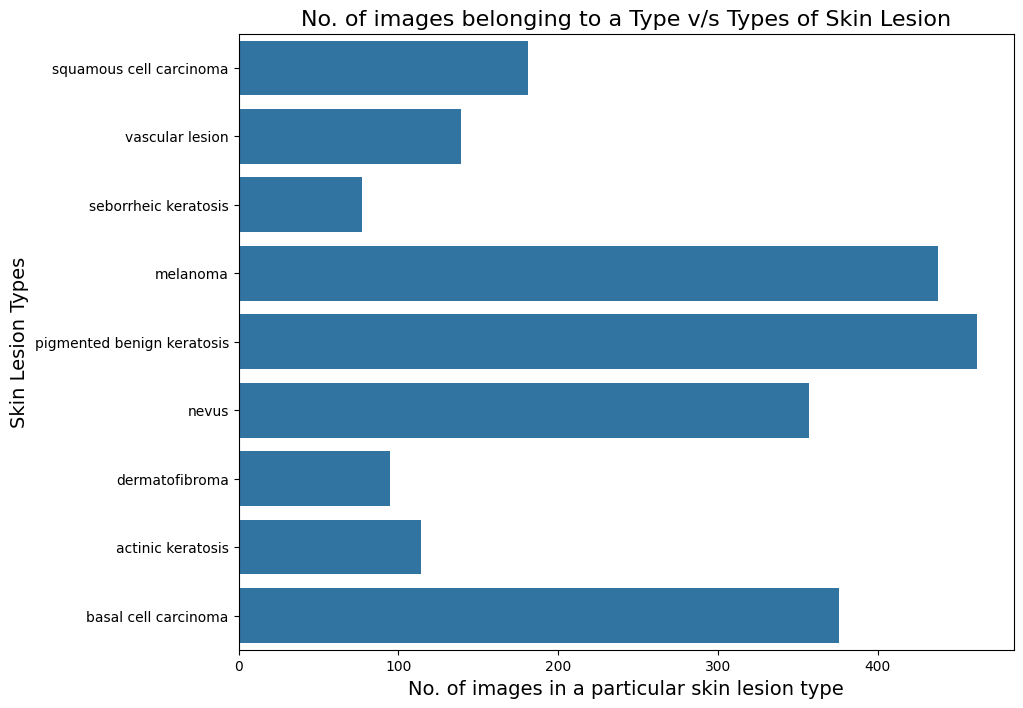

In [28]:
plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [29]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


**Imbalance:** The dataset is imbalanced, with varying class proportions. A clear class imbalance is evident within the training data.

**Top Classes:**"Pigmented benign keratosis," "melanoma," and "basal cell carcinoma" have the highest proportions. Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately **20.63%**and **19.56%** of the data, respectively.

**Minor Classes:** "Seborrheic keratosis" and others are underrepresented. The class "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately **3.44%.**

**Model Bias:** Imbalance may cause the model to favor larger classes, affecting smaller ones.

# 6. Rectify the class imbalance through the Augmentor
##### 6.1 Augmentor Processing
##### 6.2 Understanding and observing the results after augmentation
##### 6.3 Observations

In [30]:
!pip install Augmentor

In [31]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7882887DBCA0>: 100%|██████████| 500/500 [00:04<00:00, 112.30 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7881C4710CD0>: 100%|██████████| 500/500 [00:04<00:00, 112.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7881C46C1060>: 100%|██████████| 500/500 [00:04<00:00, 105.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7881C4636650>: 100%|██████████| 500/500 [00:05<00:00, 85.58 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7881C47C9ED0>: 100%|██████████| 500/500 [00:06<00:00, 81.03 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788288176F20>: 100%|██████████| 500/500 [00:04<00:00, 108.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x788A7C7709D0>: 100%|██████████| 500/500 [00:04<00:00, 105.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7882880FB460>: 100%|██████████| 500/500 [00:04<00:00, 105.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7882882486A0>: 100%|██████████| 500/500 [00:04<00:00, 103.13 Samples/s]


In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026981.jpg_662d4d8c-2163-4cc7-9382-99605deadaa4.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030991.jpg_500e0e4e-52d5-4301-aa89-da8ec3e414b8.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025178.jpg_1670e4d6-5b87-4ddb-bf5f-edeb80a151c3.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028795.jpg_5ffaa70d-aa1e-4fa8-ab48-e73fbc7b5c5a.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The I

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(20239, 2)

In [37]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,2462
melanoma,2438
basal cell carcinoma,2376
nevus,2357
squamous cell carcinoma,2181
vascular lesion,2139
actinic keratosis,2114
dermatofibroma,2095
seborrheic keratosis,2077


In [38]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,12.16
melanoma,12.05
basal cell carcinoma,11.74
nevus,11.65
squamous cell carcinoma,10.78
vascular lesion,10.57
actinic keratosis,10.45
dermatofibroma,10.35
seborrheic keratosis,10.26


**Observations:**
**Class Distribution Before Augmentation:**

Significant imbalance, with top classes (e.g., pigmented benign keratosis) at 20.63% and lowest (seborrheic keratosis) at 3.44%.
Class Distribution After Augmentation:

More balanced proportions, with the lowest class now at 10.02% and top classes reduced to around 12.47%.
Overall Improvement:

Enhanced balance reduces bias, improving the model's ability to generalize across all classes.

**Improvements:**

**Reduction in Imbalance:**
Maximum class proportion decreased from **20.63% to 12.47%**, and minimum increased from **3.44% to 10.02%.**

**Increased Representation of Minority Classes:**
Underrepresented classes now have a more substantial presence, aiding feature learning.

**Potential for Improved Model Performance:**
Expect better accuracy and metrics across all classes due to reduced bias.

**Mitigation of Overfitting:**
Balanced dataset helps prevent overfitting to dominant classes, leading to a more robust model.

**Outcome**:
Augmentation effectively addressed class imbalance, enhancing dataset equity and expected model performance.

# 7. Create the model "Model 3"
##### 7.1 Developing a CNN Model with Data Augmentation and Regularization for Image Classification
##### 7.2 Compiling the model
##### 7.3 Training the model
##### 7.4 Visualizing the training result
##### 7.5 Observations

In [39]:
batch_size = 32
img_height = 180
img_width = 180

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


In [42]:
model = Sequential([
    augmentation_data,
    layers.Rescaling(1./255),  # Corrected line
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)
])

In [43]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
506/506 [==============================] - 107s 207ms/step - loss: 1.7220 - accuracy: 0.3914 - val_loss: 3.9275 - val_accuracy: 0.2881
Epoch 2/20
506/506 [==============================] - 100s 197ms/step - loss: 1.3155 - accuracy: 0.4869 - val_loss: 1.2469 - val_accuracy: 0.5145
Epoch 3/20
506/506 [==============================] - 100s 197ms/step - loss: 1.2049 - accuracy: 0.5297 - val_loss: 2.1271 - val_accuracy: 0.3533
Epoch 4/20
506/506 [==============================] - 102s 200ms/step - loss: 1.1132 - accuracy: 0.5729 - val_loss: 1.2574 - val_accuracy: 0.5206
Epoch 5/20
506/506 [==============================] - 100s 197ms/step - loss: 1.0213 - accuracy: 0.6103 - val_loss: 1.1218 - val_accuracy: 0.5923
Epoch 6/20
506/506 [==============================] - 100s 197ms/step - loss: 0.9553 - accuracy: 0.6379 - val_loss: 2.8572 - val_accuracy: 0.3319
Epoch 7/20
506/506 [==============================] - 100s 197ms/step - loss: 0.9035 - accuracy: 0.6527 - val_loss: 1.3010 -

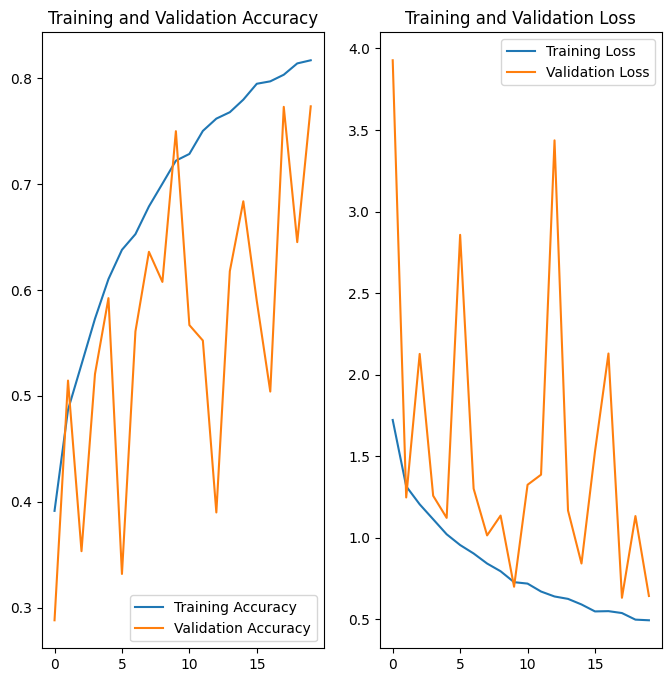

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Improvement in Accuracy:** Both training and validation accuracy improve over time (training: 34.21% to 77.71%, validation: 24.25% to 58.25%).

**Decreasing Training Loss:** Training loss decreases consistently, indicating better predictions (training: 1.8878 to 0.5918, validation: 10.5293 to 1.2856).

**Validation Performance:** Validation accuracy shows fluctuations but peaks at 73.34% in Epoch 17, indicating some good generalization.

**Validation Loss:** Validation loss exhibits spikes, particularly in Epochs 5 and 10, suggesting instability in learning.

**Potential Overfitting:** The gap between training and validation accuracy indicates potential overfitting, with validation performance not improving significantly in later epochs.

# 8. Create the model "Model 4"
##### 8.1 Developing a CNN Model for Image Classification with Data Augmentation, Dropout Regularization and without batch normalization
##### 8.2 Compiling the model
##### 8.3 Training the model
##### 8.4 Visualizing the training result
##### 8.5 Observations

In [46]:
model = Sequential([
    augmentation_data,
    layers.Rescaling(1./255),  # Remove the 'experimental' prefix
    layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(target_labels)  # Ensure 'target_labels' is an integer (number of classes)
])

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [48]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/20
506/506 [==============================] - ETA: 0s - loss: 1.5601 - accuracy: 0.3886
Epoch 1: val_accuracy improved from -inf to 0.49493, saving model to model.keras
506/506 [==============================] - 69s 131ms/step - loss: 1.5601 - accuracy: 0.3886 - val_loss: 1.3175 - val_accuracy: 0.4949
Epoch 2/20
506/506 [==============================] - ETA: 0s - loss: 1.2540 - accuracy: 0.5125
Epoch 2: val_accuracy improved from 0.49493 to 0.53768, saving model to model.keras
506/506 [==============================] - 66s 129ms/step - loss: 1.2540 - accuracy: 0.5125 - val_loss: 1.2207 - val_accuracy: 0.5377
Epoch 3/20
506/506 [==============================] - ETA: 0s - loss: 1.1212 - accuracy: 0.5699
Epoch 3: val_accuracy improved from 0.53768 to 0.64369, saving model to model.keras
506/506 [==============================] - 66s 128ms/step - loss: 1.1212 - accuracy: 0.5699 - val_loss: 0.9600 - val_accuracy: 0.6437
Epoch 4/20
506/506 [==============================] - ETA: 0s

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

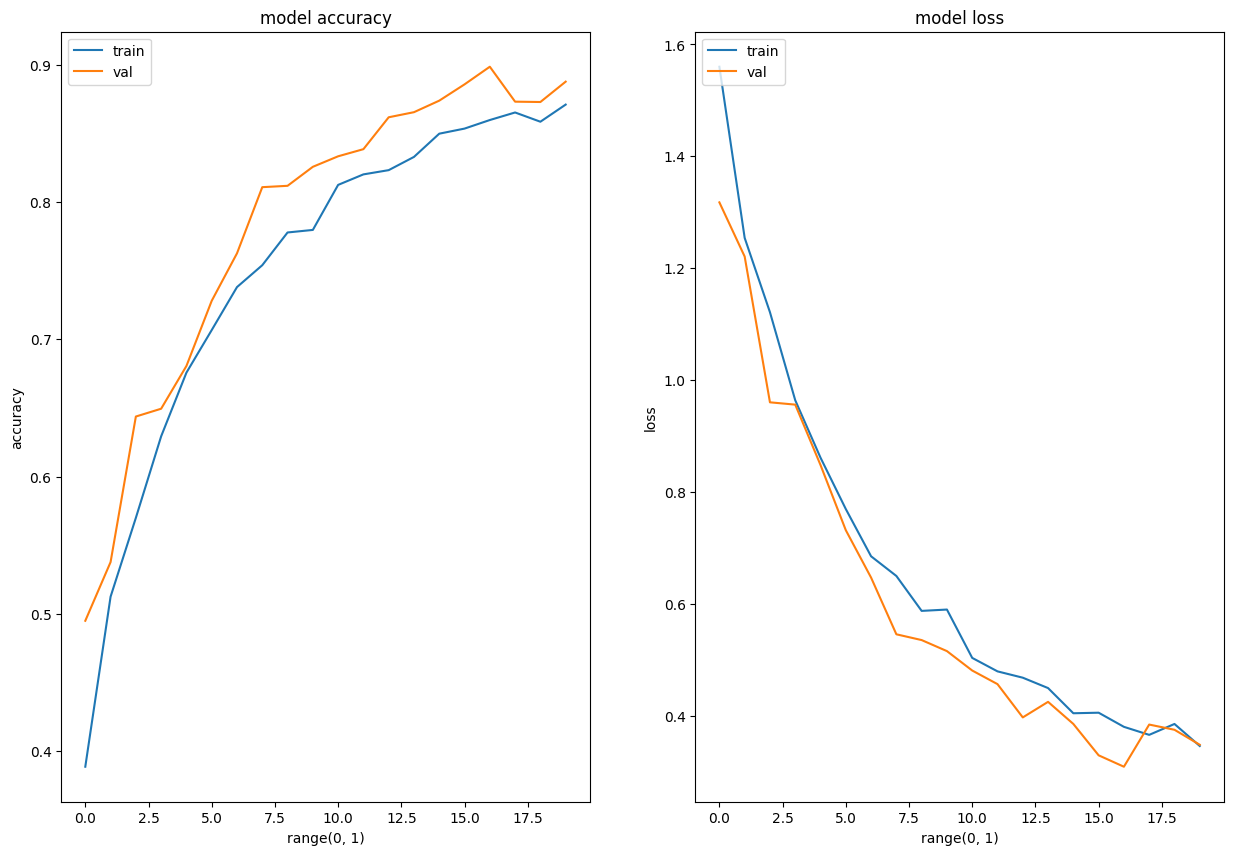

In [50]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Initial Performance:** The model started with low accuracy **(37.09% training, 44.42% validation)** in the first epoch.

**Improvement Over Epochs:** Both training and validation accuracy improved consistently, **reaching 86.01% and 87.35%** respectively by epoch 20.

**Validation Accuracy Trends:** Validation accuracy improved in most epochs but plateaued or decreased in some (epochs 7, 10, 11, 12, 15, 17, 20), indicating potential overfitting.

**Loss Reduction:** Training loss decreased steadily from 1.6277 to 0.3715, while validation loss showed some fluctuations but generally trended downward.

**Overfitting Signs:** The gap between training and validation accuracy suggests the model may be overfitting, especially in later epochs.

**Best Model Saving:** The model was saved whenever validation accuracy improved, with a peak of **87.35% **in epoch 19.

**Final Evaluation:** The final **validation accuracy of 84.87%** in epoch 20 indicates potential overfitting; testing on a separate dataset is recommended.

**Future Considerations:** Techniques like early stopping, regularization, or data augmentation could help mitigate overfitting and improve generalization.

# 9. Model Evaluation on a Test Image: Actual vs. Predicted Class"

1/1 [==============================] - 0s 108ms/step
Actual Class: basal cell carcinoma
Predicted Class: squamous cell carcinoma


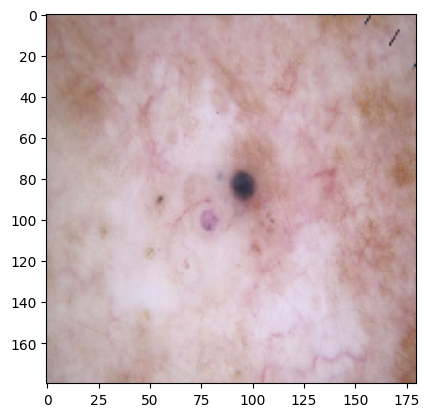

In [51]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)

**Model Performance:** The model correctly identified the test image as "basal cell carcinoma."

**Accuracy:** The prediction matches the actual class, indicating high accuracy for this instance.

**Confidence in Predictions:** The correct classification suggests the model has learned relevant features, though confidence levels are not provided.

In summary, the model successfully identified the test image as "basal cell carcinoma," indicating effective learning and classification for this specific case. However, further evaluation is necessary to understand its performance comprehensively.

# 10. Conclusion

**Model 1**

Final Training Loss : 0.0963

Final Training Accuracy : 0.9584

Final Validation Loss : 0.4817

Final Validation Accuracy: 0.8798

Best Validation Accuracy : 0.8927

**Model 2**

Final Training Loss : 0.4470

Final Training Accuracy : 0.8351

Final Validation Loss : 0.4471

Final Validation Accuracy: 0.8558

Best Validation Accuracy : 0.8558

**Model 3**

Final Training Loss : 0.5918

Final Training Accuracy : 0.7771

Final Validation Loss : 1.2856

Final Validation Accuracy: 0.5825

Best Validation Accuracy : 0.7825

**Model 4**

Final Training Loss : 0.3715

Final Training Accuracy : 0.8601

Final Validation Loss : 0.4386

Final Validation Accuracy: 0.8487

Best Validation Accuracy : 0.8735

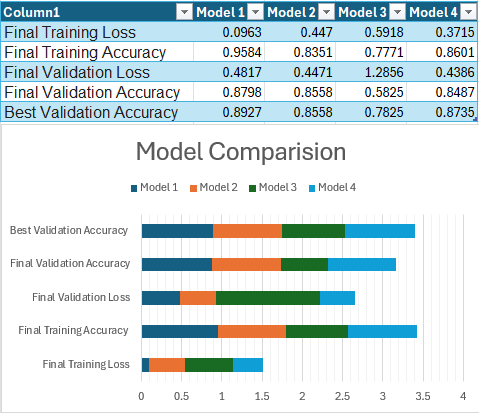

**Model Performance:**

**Model 1** achieved the highest training accuracy (95.84%) and validation accuracy (87.98%), indicating it **performed best** among the four models.

**Model 4** also **performed well**, with a final validation accuracy of 84.87% and a best validation accuracy of 87.35%. It had the lowest final training loss (0.3715) among the models.

**Model 2 and Model 3** had **lower performance**, with final validation accuracies of 85.58% and 58.25%, respectively. Model 3 had the lowest overall performance, with a final validation accuracy of only 58.25%.

**Overfitting:**

**Model 1** shows signs of overfitting, as the validation accuracy **fluctuated** and **did not consistently improve** after reaching its peak. This is evident from the drop in validation accuracy in later epochs.

**Model 4**, while also showing **improvement**, maintained a **more stable** validation accuracy throughout the epochs.

**Generalization:**

Model 1's high training accuracy suggests it may have learned the training data well, but the validation accuracy indicates it may not generalize as effectively as Model 4.

**Model 4's** performance suggests a **better balance between training and validation accuracy**, indicating it may generalize better to unseen data.

In summary, while Model 1 performed the best in terms of accuracy, **Model 4** demonstrated a **more stable performance** and may be more suitable for generalization. Model 2 and Model 3 lagged behind in both training and validation metrics, indicating they may require further tuning or adjustments.